# Tehtävä 5 - A Star -algoritmi
Hannu Karstu - TTV19SAI

## Tehtävänanto
- Tee ohjelma, joka tekee reitinhaun karttaan
    - Leveli määritellään 2 ulotteisena numpy taulukkona, jossa 0 tarkoittaa kuljettavissa olevaa solmua ja 1 seinää, jonka läpi ei voi kulkea
    - Testilevelin koko 20x20
    - Testilevelissä pitää olla seiniä esteinä, jotta varmistutaan algoritmin oikeanlainen toiminta
- Koodaa A* algoritmi niin, että A* on omana funktionaan/luokkana erillisessä tiedostossa, joka sitten importataan testisovelluksen tiedostossa (modulaarinen ajattelu)
- A) Ohjelma generoi satunnaisia lähtö ja maalipisteitä (10 kpl) ja suorittaa reitinhaun kullekkin lähtö/maalipisteelle levelissä:
    - Ohjelma tulostaa levelin ruudulle, ennen hakua (pelkät lähtö ja maalipisteet+seinät)
    - Ohjelma tulostaa levelin ruudulle, jossa näkyy reitinhaun tulos (lähtö+maalipiste+seinät+reitti).
- B) Ohjelma hakee reitin A:sta B:hen kahdella erilaisella heuristiikan painotuksella. Visualisoi OpenListin sisältö karttaan, esim jollakin kirjaimella.

## 1. Importit

In [1]:
import random
import math  
import numpy as np

from time import sleep 
from os import system, name

from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## 2. Luodaan sokkelo

In [2]:
def createMaze():
    maze = np.array([
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,],
        [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,],
        [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,],
             ])
    return maze

## 3. Piirretään sokkelo

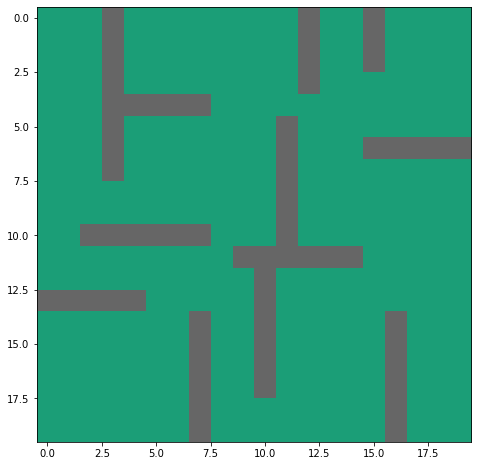

In [3]:
fig, ax = plt.subplots(figsize=(8,8))

ax.imshow(createMaze(), cmap=plt.cm.Dark2)

plt.show()

## 4. Generoidaan lähtö- ja maalipisteet

In [4]:
def createStartsAndGoals(amount,maze):
    # Listat aloitus- ja lopetuspisteille
    starting_points = []
    goal_points = []

    # Lisätään listoihin 10 aloitus- ja lopetuspistettä,
    # jotka eivät ole seinien sisällä
    for i in range (0,amount):
        while True:
            X_start = random.randint(0,19)
            Y_start = random.randint(0,19)
            X_goal = random.randint(0,19)
            Y_goal = random.randint(0,19)

            # Tarkistetaan ettei olla seinän sisällä
            if maze[X_start,Y_start] == 0 and maze[X_goal,Y_goal] == 0:
                # Tarkistetaan ettei aloitus- ja lopetus ole sama piste
                if X_start != X_goal and Y_start != Y_goal:
                    break

        # Lisätään listalle       
        starting_points.append([X_start,Y_start])
        goal_points.append([X_goal,Y_goal])

    print("Starting points:",starting_points)
    print("Goal points:",goal_points)
    
    return starting_points, goal_points

## 5. Node-luokka

In [5]:
class Node:
    def __init__(self, pos):
        # Sijainti
        self.pos = pos
        
        # Mistä nodesta tultiin tähän nodeen.
        self.parent = None
        
        # f = Kokonaiskustannus
        # f = g+h
        self.f = 0
        
        # etäisyyskustannus start -> oma sijainti
        self.g = 0
        
        # etäisyys oma sijainti -> goal
        self.h = 0
    
    # Uuden sijainnin määrittäminen child-nodeille
    #  neljään ilmansuuntaan
    def newPos(self, direction):
        pos = self.pos
        
        # vasen
        if direction == 0:
            self.pos = (pos[0]-1,pos[1])
            
        # oikea
        elif direction == 1:
            self.pos = (pos[0]+1,pos[1])
            
        # ylös
        elif direction == 2:
            self.pos = (pos[0],pos[1]+1)
            
        # alas
        elif direction == 3:
            self.pos = (pos[0],pos[1]-1)
            
        

## 6. Valmiin reitin piirto
- Piirtää reitinhakualgoritmin etsimän parhaan reitin kartalle

In [6]:
def plotPath(path, maze, heuristic):
    for i in path:
        clear_output(wait=True)    

        maze[i[0]][i[1]] = 2

        fig, ax = plt.subplots(figsize=(8,8))

        ax.imshow(maze, cmap=plt.cm.Dark2)
        
        title = 'Path found with heuristic '+str(heuristic)
    
        fig.suptitle(title, fontsize=16)

        ax.scatter(start[1],start[0], marker = "*", color = "yellow", s = 400)

        ax.scatter(goal[1],goal[0], marker = "*", color = "red", s = 200)

        plt.show()

## 7. Reitinhaun piirto
- Piirtää kartalle reitinhakualgoritmin vaiheet

In [7]:
speed = 0.001


def plotFind(start,goal,heuristic):
    #sleep(speed)
    clear_output(wait=True)

    fig, ax = plt.subplots(figsize=(8,8))

    ax.imshow(maze, cmap=plt.cm.Dark2)

    ax.scatter(start[1],start[0], marker = "*", color = "yellow", s = 400)
    
    title = 'Pathfinding with heuristic '+str(heuristic)
    
    fig.suptitle(title, fontsize=16)

    ax.scatter(goal[1],goal[0], marker = "*", color = "red", s = 200)

    plt.show()

## 8. Algoritmit

In [8]:
# Etäisyydenlaskentafunktio sijainnista maaliin
def calculateH(pos, goal, heuristic):
    X = pos[0] - goal[0]
    Y = pos[1] - goal[1]
    
    if heuristic == "euclidean":
        return (math.sqrt(X**2 + Y**2))
    
    elif heuristic == "manhattan":
        X_abs = math.sqrt(X**2)
        Y_abs = math.sqrt(Y**2)
        return (X_abs + Y_abs)
    
    # Kuin euclidinen, mutta ei oteta neliöjuurta
    elif heuristic == "best":
        return ((X**2 + Y**2))

    
# Tämän avulla järjestetään open_list
def get_my_key(obj):
    return obj['f']


# Itse algoritmi
def astar(maze,start_pos,goal_pos,heuristic):
    # Määritetään aloitusnode
    start = Node(start_pos)
    start.g = start.h = start.f = 0
    
    # Määritetään lopetusnode
    goal = Node(goal_pos)
    goal.g = goal.h = goal.f = 0

    
    start.h = calculateH(start.pos,goal.pos,heuristic)
    
    # Nodet joihin mennään
    open_list = []
    
    # Nodet joissa käyty
    closed_list = []
    
    open_list.append(start)
    
    while len(open_list) > 0:

        # Järjestetään pienin f, eli matka maaliin ekaksi
        open_list = sorted(open_list, key=lambda x: x.f)
        
        current = open_list[0]
        current.h = calculateH(current.pos,goal.pos,heuristic)
        current.f = current.h + current.g
        
        maze[current.pos[0]][current.pos[1]] = 3
        
        # Tätä ei käytetä ollenkaan. Tein sittenkin tarkastelun taulukon avulla.
        closed_list.append(current)
        open_list.pop(0)      
        
        
        # Kun ollaan maalissa
        if current.pos == goal.pos:
            
            # Polku jota pitkin kuljetaan
            path = []
            current_node = current
            while current_node is not None:
                path.append(current_node.pos)
                current_node = current_node.parent
            
            print("YOU DID IT!")
            
            # Palautetaan polku käänteisessä järjestyksessä.
            return path[::-1]
        
        
        
        child_nodes = []
        
            
        # Käydään jokainen pääilmansuunta läpi
        for direction in range (0,4):

            # Kopioidaan lapseksi nykyinen node
            child = Node(current.pos)

            # Määritetään lapsen vanhempi
            child.parent = current

            # Otetaan lapselle uusi sijainti
            child.newPos(direction)

            # Onko lapsi kartalla:
            if child.pos[0] > -1 and child.pos[0] < maze.shape[0] and child.pos[1] > -1 and child.pos[1] < maze.shape[1]:
                
                # Onko lapsi seinän sisällä:
                if maze[child.pos[0]][child.pos[1]] != 1:
                    
                    # Lapsi ei voi olla käyty solu
                    if maze[child.pos[0]][child.pos[1]] != 3:
                        
                        # Lapsi ei voi olla jonkun muun lapsen paikalla
                        if maze[child.pos[0]][child.pos[1]] != 2:
                            child.h = calculateH(child.pos,goal.pos,heuristic)
                            child.g = current.g + 1
                            child.f = child.h + child.g

                            # Lisätään lapsilistaan
                            open_list.append(child) 

                            # Plotataan lapsi kartalle näkyville
                            maze[child.pos[0]][child.pos[1]] = 2
                            plotFind(start_pos,goal_pos,heuristic)

## 9. Funktion ajo
- a. luodaan sokkelo
- b. luodaan aloitus- ja lopetuspisteet
- c. ajetaan reitinhaku niin monta kierrosta kuin aloitus- ja lopetuspisteitä on
- d. ajetaan jokaiselle aloitus- ja lopetuspisteelle 3 erilaista heuristiikkaa
- e. piirretään reitinhaku kartalle
- f. piirretään löydetty reitti kartalle.

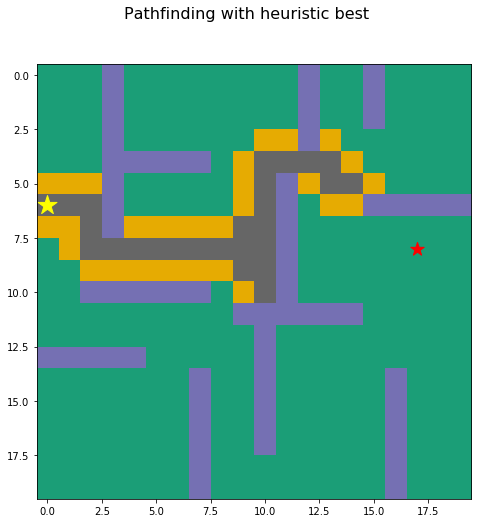

In [ ]:
# Luodaan sokkelo
maze = createMaze()

# Luodaan aloitus- ja lopetuspisteet, parametrina määrä
starting_points, goal_points = createStartsAndGoals(10,maze)

# Montako kierrosta mennään
rounds = len(starting_points)


for i in range(0,rounds):
    # Luodaan sokkelo uudestaan joka kierroksen alussa
    maze = createMaze()
    
    # Monesko aloituspiste:
    start_number = goal_number = i
    
    # Määritetään aloitus- ja lopetuspiste listalta
    start = (starting_points[start_number][0],starting_points[start_number][1])
    goal = (goal_points[goal_number][0],goal_points[goal_number][1])
    
    heuristics = ["euclidean","manhattan","best"]
    
    for heuristic in heuristics:
        maze = createMaze()
        # Otetaan kartta talteen reitinpiirtoa varten
        pathMaze = maze.copy()

        #heuristic = "manhattan"
        #heuristic = "euclidean"
        #heuristic = "best"  # Kuin euclidean, mutta ei oteta neliöjuurta

        # Ajetaan astar ja otetaan reitti path-muuttujaan
        path = astar(maze,start,goal,heuristic)

        # Piirretään reitti
        plotPath(path,pathMaze,heuristic)